In [1]:
using Pkg

In [ ]:
Pkg.add("LibSndFile")
Pkg.add("FileIO")
#Pkg.add("WGLMakie")
Pkg.add("CairoMakie")
Pkg.add("WAV")
Pkg.add("SampledSignals")
Pkg.add("FFTW")

In [2]:
using LibSndFile
using FileIO
using FFTW
using SampledSignals

In [3]:
#using WGLMakie
using CairoMakie

In [10]:
clip = load("dstn-guitar-2.wav")

([0.0; 0.0; … ; 0.0; 0.0;;], 44100.0f0, 0x0010, WAV.WAVChunk[WAV.WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x44, 0xac, 0x00, 0x00, 0x88, 0x58, 0x01, 0x00, 0x02, 0x00, 0x10, 0x00])])

In [11]:
data = clip[1]
N = length(data)

616320

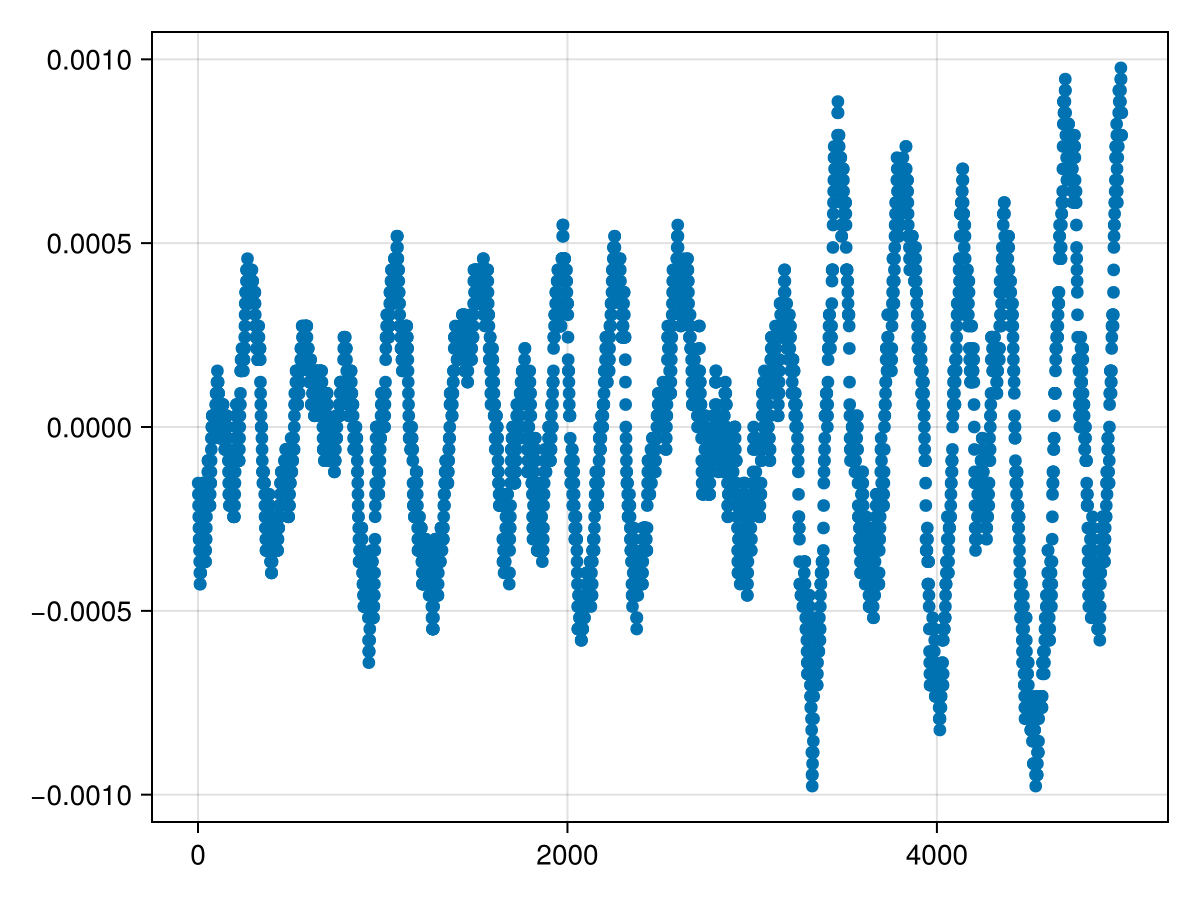

In [12]:
f = Figure()
Axis(f[1,1])
scatter!(data[15000:20000,1])
f

In [27]:
ichunk = 16
cs = 1024
i0 = (ichunk-1)*cs + 1
sub = data[i0:i0+cs*2-1]
spec = rfft(sub);
i = argmax(abs.(spec))
outspec = zero(spec)
outspec[i] = spec[i]
out = irfft(outspec, 2*cs);

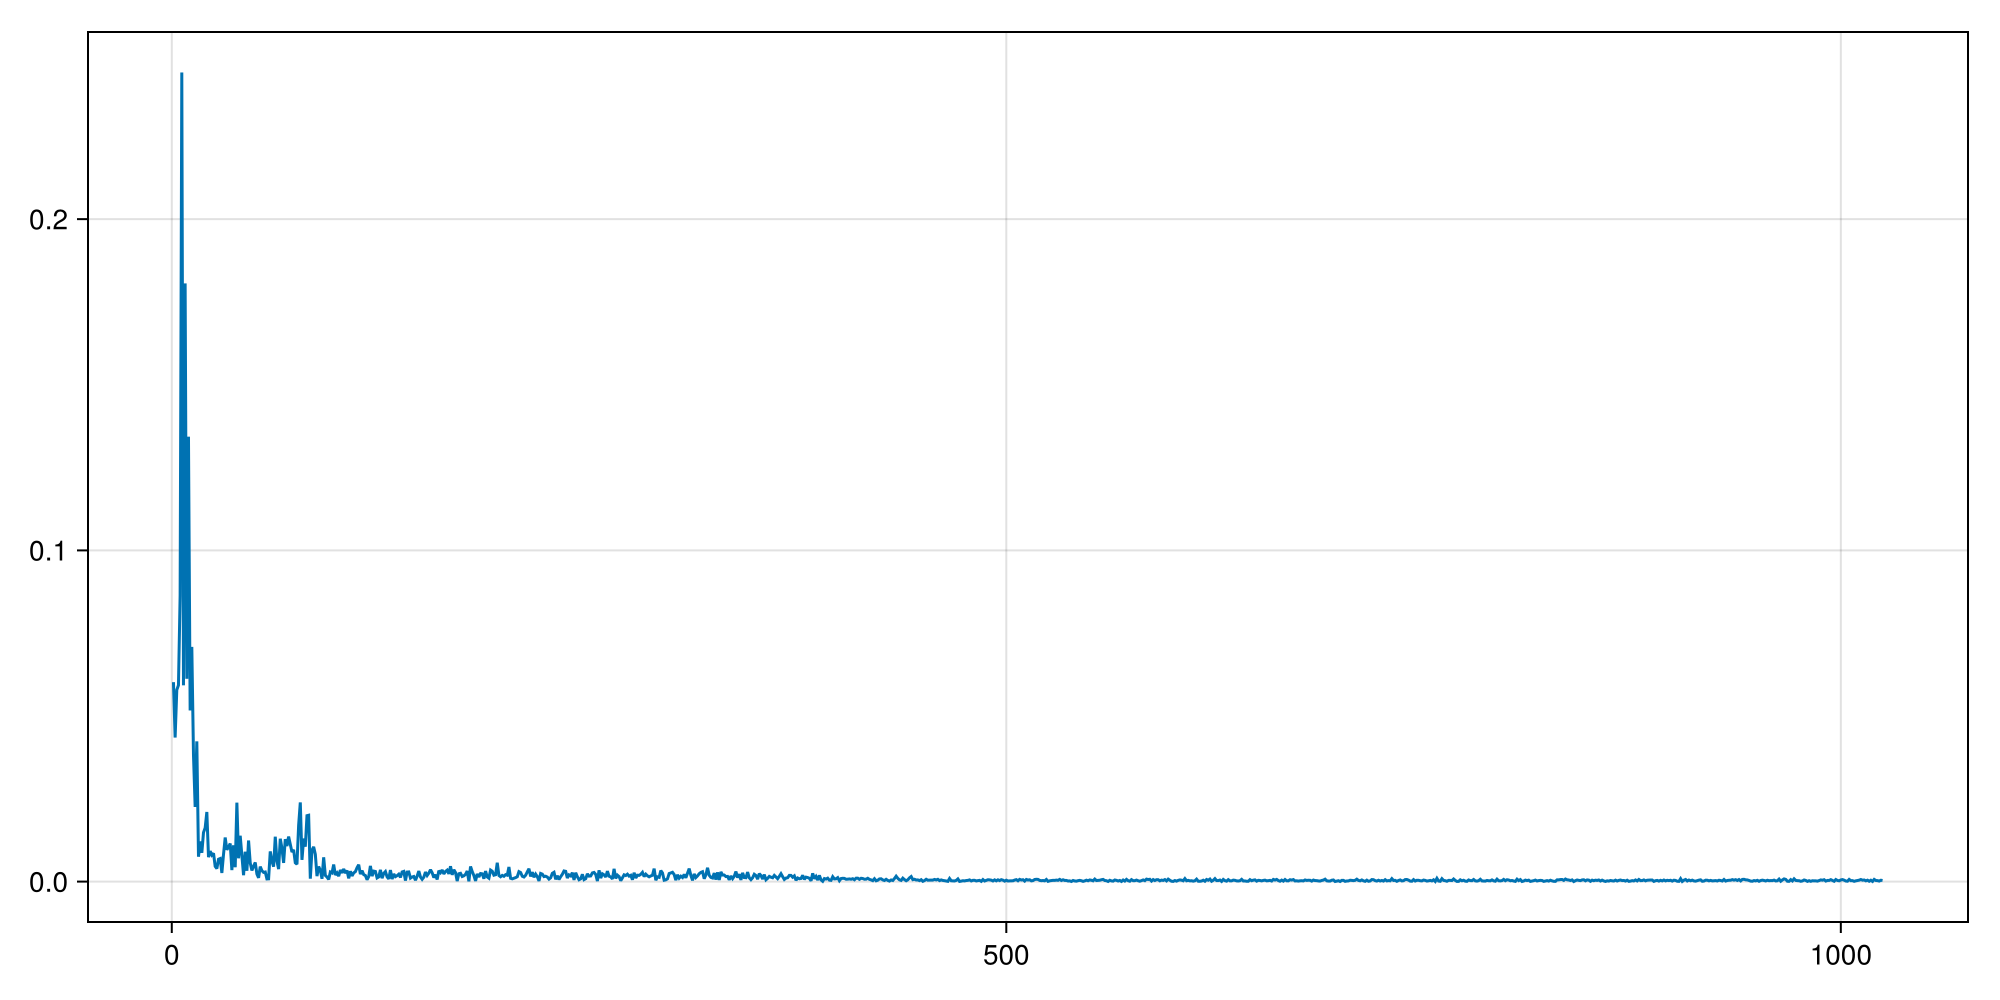

In [34]:
f = Figure(size=(1000,500))
ax = Axis(f[1,1])
lines!(abs.(spec), label="FT")
f

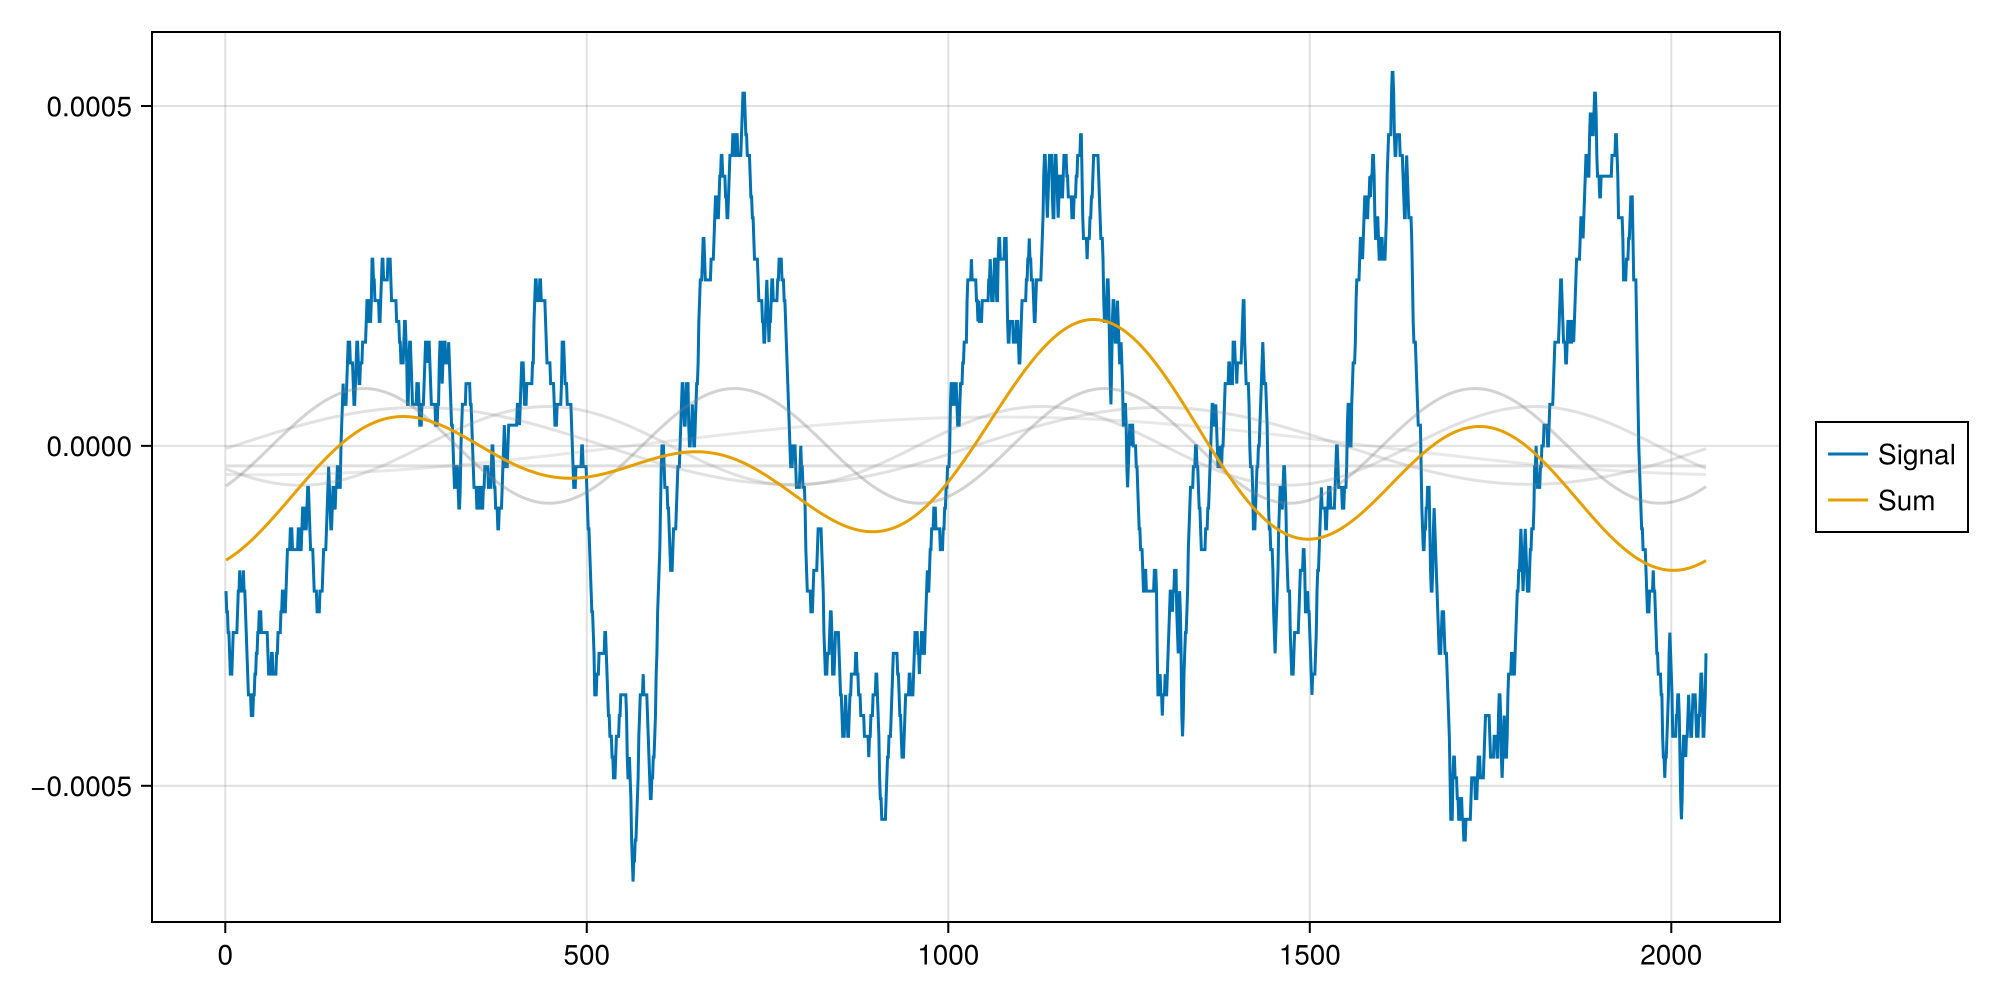

In [30]:
f = Figure(size=(1000,500))
ax = Axis(f[1,1])
lines!(sub, label="Signal")

mx = maximum(abs.(spec))
outsum = 0.
for i in 1:5
    outspec = zero(spec)
    outspec[i] = spec[i]
    out = irfft(outspec, 2*cs)
    lines!(out, color=:gray, alpha=abs.(spec[i]) / mx)
    outsum = outsum .+ out
end
lines!(outsum, label="Sum")
f[1, 2] = Legend(f, ax)
f

In [ ]:
chunksize = 2048
Nchunk = Int(floor(N/chunksize))

In [21]:
specgram = []
out_specgram = []
outdata = zeros((Nchunk * chunksize))
apod = zeros(chunksize*2)
apod[1:chunksize] = range(1, chunksize) / chunksize
apod[length(apod):-1:chunksize+1] = apod[1:chunksize]

fscale = zeros(chunksize+1)
fscale[1:1000] = sqrt.(1 ./ (1:1000))

for ichunk in 1:Nchunk-1
    # Grab a chunk of data (of length "chunksize * 2") from the sound clip
    i0 = (ichunk-1)*chunksize + 1
    sub = data[i0:i0+chunksize*2-1]

    # Take the (real) FFT
    spec = rfft(sub)
    # Record the amplitude for our spectrogram
    push!(specgram, abs.(spec))
    
    outspec = zero(spec)
    I = sortperm(-(abs.(spec)))
    Nkeep = 50
    outspec[I[1:Nkeep]] = spec[I[1:Nkeep]]
    push!(out_specgram, abs.(outspec))

    out = irfft(outspec, 2*chunksize)
    outdata[i0 : i0+chunksize*2-1] += (real(out) .* apod)
    #outdata[i0 : i0+chunksize*2-1] += (out .* apod)
end
specgram = stack(specgram);
out_specgram = stack(out_specgram);

In [22]:
save("out.wav", outdata, samplerate=44100)

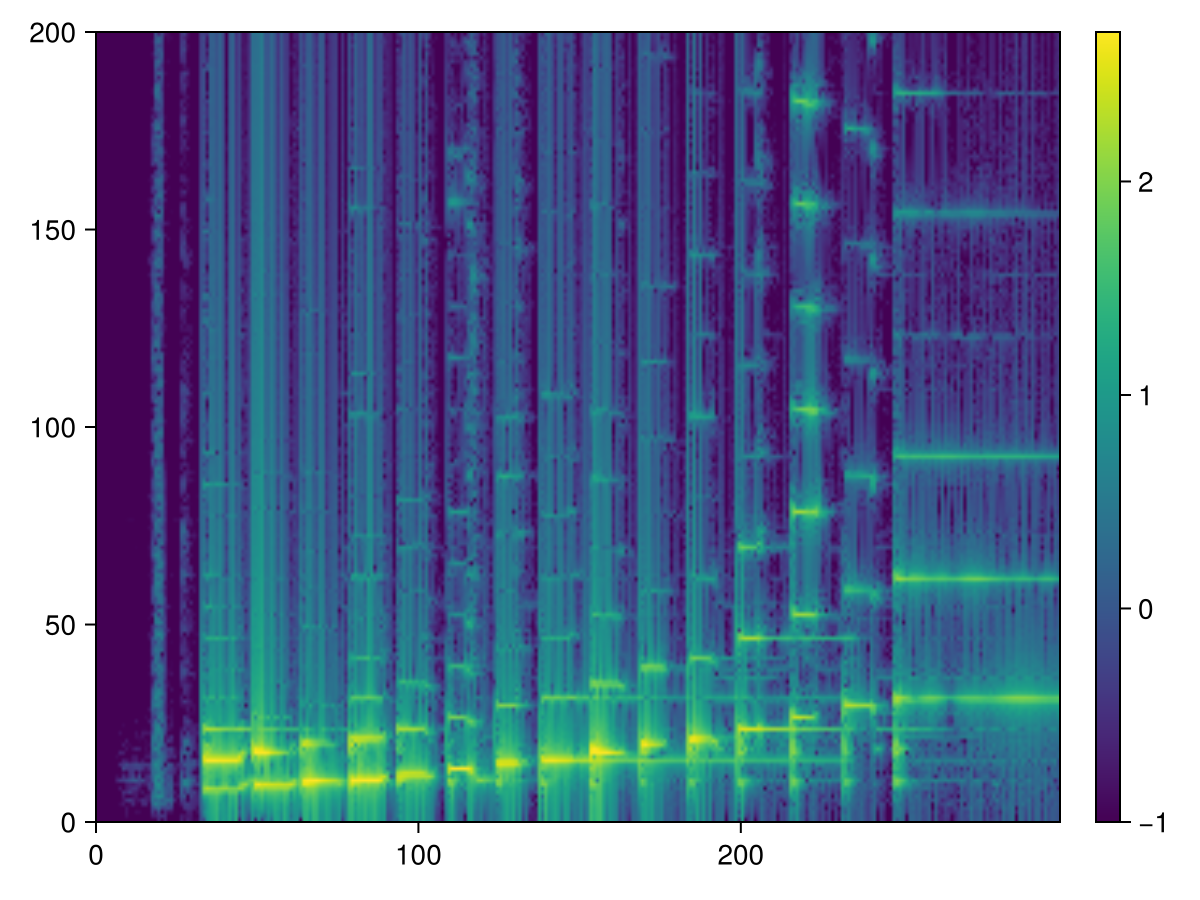

In [23]:
f = Figure()
ax,img = image(f[1,1][1,1], log10.(specgram[1:200,:]'), colormap=:viridis,
    colorrange=(-1,2.7))
Colorbar(f[1, 1][1, 2], img)
f